In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
df = pd.read_csv('F:\\Datasets\\RSCCASN.csv',parse_dates=True,index_col='DATE')

In [3]:
df.columns=['Sales']

In [4]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
len(df)

334

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [7]:
df.isnull().sum()

Sales    0
dtype: int64

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sales,334.0,16325.095808,5369.839014,6938.0,12298.5,15878.5,19772.5,34706.0


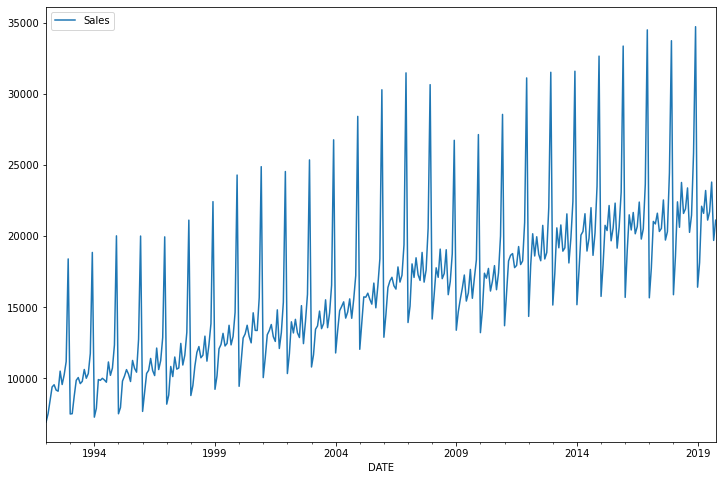

In [9]:
df.plot(figsize=(12,8))

In [10]:
test_ind = len(df)-18

In [11]:
train = df[:test_ind]
test = df[test_ind:]

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [13]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
length = 12
batch = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=batch)


In [16]:
X,y = generator[0]

In [17]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [18]:
y

array([[0.02047633]])

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [21]:
model = Sequential()
model.add(LSTM(100,input_shape=(length,batch),activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [23]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=batch)

In [24]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 6 steps
Epoch 1/20
304/304 [==============================] - 6s 20ms/step - loss: 0.0247 - val_loss: 0.0048
Epoch 2/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0168 - val_loss: 0.0380
Epoch 3/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0088 - val_loss: 0.0060


In [25]:
losses = pd.DataFrame(model.history.history)

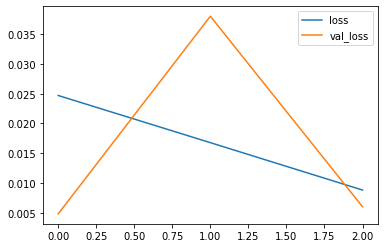

In [26]:
losses.plot()

In [27]:
test_prediction = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1,length,batch)

for i in range(18):

    current_pred = model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


In [28]:
true_predictions = scaler.inverse_transform(test_prediction)

In [29]:
test['Predictions'] = true_predictions

In [30]:
test


,Sales,Predictions
DATE,,
2018-05-01,23764,22703.001178
2018-06-01,21589,21915.857413
2018-07-01,21919,22219.801219
2018-08-01,23381,23782.980668
2018-09-01,20260,21809.673926
2018-10-01,21473,22458.295007
2018-11-01,25831,26579.426550
2018-12-01,34706,36062.237234
2019-01-01,16410,18874.935204


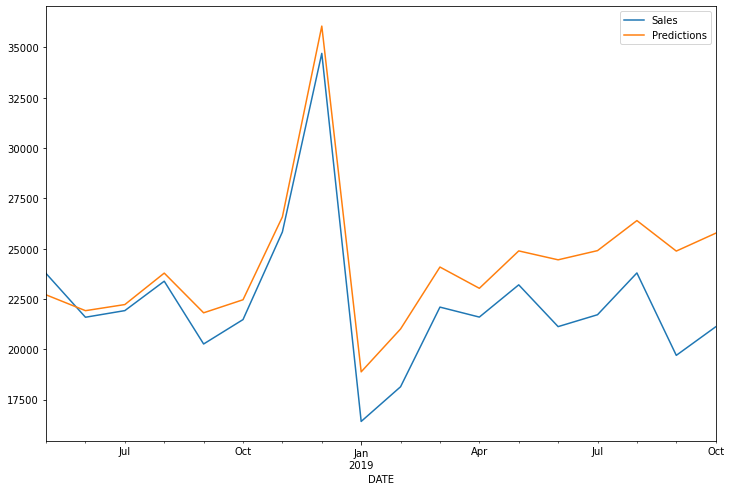

In [31]:
test.plot(figsize=(12,8))

In [32]:
full_scaler = MinMaxScaler()
scaled_full = full_scaler.fit_transform(df)

In [33]:
length = 12
generator = TimeseriesGenerator(scaled_full,scaled_full,length=length,batch_size=batch)

In [34]:
model = Sequential()
model.add(LSTM(100,input_shape=(length,batch),activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [35]:
model.fit_generator(generator,epochs=8)

  ...
    to  
  ['...']
Train for 322 steps
Epoch 1/8
322/322 [==============================] - 5s 14ms/step - loss: 0.0244
Epoch 2/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0138
Epoch 3/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0066
Epoch 4/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0047
Epoch 5/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0025
Epoch 6/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0028
Epoch 7/8
322/322 [==============================] - 3s 11ms/step - loss: 0.0016
Epoch 8/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0016


In [36]:
forecast = []
periods = 12
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1,length,batch)

for i in range(12):

    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


In [37]:
forecast = scaler.inverse_transform(forecast)

In [38]:
forecast

array([[21466.03752184],
       [20271.24140191],
       [20470.19363284],
       [22299.9399786 ],
       [19616.89800024],
       [20261.41552615],
       [24546.60964298],
       [36284.78305912],
       [15388.59956217],
       [18245.74752188],
       [22114.41890717],
       [20551.44960308]])

In [39]:
forecast_index = pd.date_range(start='2019-11-1',periods=periods,freq='MS')

In [40]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [41]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])

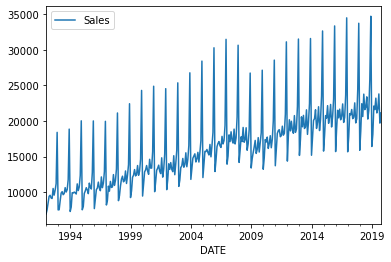

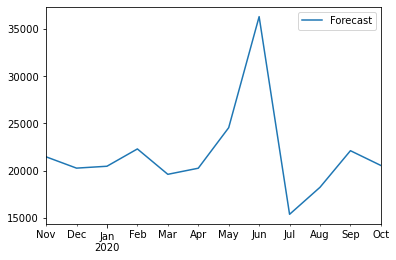

In [42]:
df.plot()
forecast_df.plot()

(576.0, 611.0)

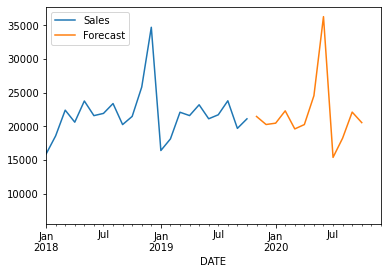

In [43]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01',"2020-12-01")